# Deep Learning with Pytorch Chapter 6

## 1. Neural Networks

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

In [28]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_c.shape, t_c

(torch.Size([11, 1]), tensor([[ 0.5000],
         [14.0000],
         [15.0000],
         [28.0000],
         [11.0000],
         [ 8.0000],
         [ 3.0000],
         [-4.0000],
         [ 6.0000],
         [13.0000],
         [21.0000]]))

### train/validation split

In [29]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  0,  7,  3,  9,  1,  5,  8,  4]), tensor([6, 2]))

In [30]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

# data normaliation! Numerical Analysis [-1, 1], mean, std , (x-mean)/std;    -1, 1; Normal Distribution; Standardization 
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

### First use of `torch.nn` 

In [31]:
import torch.nn as nn

linear_model = nn.Linear(in_features=1, out_features=1, bias=True) # <1>
linear_model(t_un_val)

tensor([[-2.1152],
        [-3.2534]], grad_fn=<AddmmBackward>)

In [32]:
linear_model?

Signature:      linear_model(*input, **kwargs)
Type:           Linear
String form:    Linear(in_features=1, out_features=1, bias=True)
File:           c:\users\vip\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\linear.py
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(N, *, H_{in})` where :math:`*` means any number of
      additional dimensions and :math:`H_{in} = \text{in\_features}`
    - Output: :math:`(N, *, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(\text{out\_features}, \text{in\_features})`. The values are
        initialize

In [33]:
dir(linear_model)

['__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bias',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'in_features',
 'load_

In [34]:
linear_model.weight

Parameter containing:
tensor([[-0.4684]], requires_grad=True)

In [35]:
linear_model.bias

Parameter containing:
tensor([-0.5272], requires_grad=True)

### input shape must be $N\times F$

In [36]:
x = torch.randn(100, 1) # 10 samples of 1 dimensional feature vector
x.shape, linear_model(x).shape

(torch.Size([100, 1]), torch.Size([100, 1]))

### parameter tensors can be collected.

In [37]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = torch.optim.SGD(
                            linear_model.parameters(), # <2>
                            lr=1e-2)

In [38]:
linear_model.parameters()

<generator object Module.parameters at 0x000001D1C9F376C8>

In [39]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.6045]], requires_grad=True), Parameter containing:
 tensor([-0.2049], requires_grad=True)]

### Training loop as usual

In [40]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    history = {'tr': [], 'val': []}
    
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        with torch.no_grad():
            t_p_val = model(t_u_val) # <1>
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(loss_train), float(loss_val)))

        history['tr'].append(loss_train.item())
        history['val'].append(loss_val.item())
    #
    return history
#

### Define loss function, model, optimizer and train.

In [41]:
# custom loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
#

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 328.5552978515625, Validation loss 199.8538360595703
Epoch 1000, Training loss 3.8639025688171387, Validation loss 1.728419303894043
Epoch 2000, Training loss 2.8137943744659424, Validation loss 3.961026906967163
Epoch 3000, Training loss 2.7799644470214844, Validation loss 4.513307094573975

Parameter containing:
tensor([[5.4907]], requires_grad=True)
Parameter containing:
tensor([-18.3002], requires_grad=True)


### Use pytorch loss function, ready-made

In [42]:
loss_fn = nn.MSELoss()
    
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 294.1035461425781, Validation loss 182.89353942871094
Epoch 1000, Training loss 3.699416160583496, Validation loss 1.8809089660644531
Epoch 2000, Training loss 2.8084988594055176, Validation loss 4.012113571166992
Epoch 3000, Training loss 2.7797932624816895, Validation loss 4.523253440856934

Parameter containing:
tensor([[5.4922]], requires_grad=True)
Parameter containing:
tensor([-18.3091], requires_grad=True)


### Now, more complex model can be designed with `nn.Sequential()`

In [49]:
seq_model = nn.Sequential(
                            nn.Linear(1, 13), # <1>
                            nn.Tanh(),
                            nn.Linear(13, 1)
                ) # <2>
seq_model # seq_model[0]

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [52]:
seq_model[0](t_u)

tensor([[ 17.8172,  20.9104,  14.9051,   0.5714,  23.8545, -18.7580, -18.7838,
          -8.6052, -13.9346,  14.7541, -27.1784,  17.9670,  33.8176],
        [ 28.3843,  33.1858,  23.8804,   1.2214,  37.3349, -28.9166, -29.1194,
         -13.1910, -22.0519,  23.2386, -42.8397,  27.7873,  53.1769],
        [ 29.5874,  34.5835,  24.9024,   1.2954,  38.8698, -30.0733, -30.2963,
         -13.7132, -22.9761,  24.2047, -44.6230,  28.9054,  55.3812],
        [ 41.9855,  48.9858,  35.4329,   2.0579,  54.6858, -41.9921, -42.4227,
         -19.0936, -32.4998,  34.1593, -62.9979,  40.4273,  78.0949],
        [ 28.5935,  33.4288,  24.0582,   1.2342,  37.6018, -29.1178, -29.3241,
         -13.2818, -22.2126,  23.4066, -43.1499,  27.9818,  53.5603],
        [ 24.7224,  28.9319,  20.7702,   0.9961,  32.6635, -25.3963, -25.5378,
         -11.6019, -19.2390,  20.2985, -37.4125,  24.3842,  46.4683],
        [ 16.8755,  19.8165,  14.1053,   0.5135,  22.6533, -17.8528, -17.8628,
          -8.1966, -13.2113

In [53]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

### every parameter tensor has a name

In [54]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


### We can give a specific name to each of the layer using `OrderedDict`

In [55]:
from collections import OrderedDict

seq_model = nn.Sequential(
                            OrderedDict([
                                        ('hidden_linear', nn.Linear(1, 8)),
                                        ('hidden_activation', nn.Tanh()),
                                        ('output_linear', nn.Linear(8, 1))
                                        ]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

### parameter names are determined automatically based on the layer's name

In [56]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


### the weight and bias tensors can be accessed

In [57]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.2922], requires_grad=True)

### Let's train the complex two layer model

In [70]:
seq_model = nn.Sequential(
                            OrderedDict([
                                        ('hidden_linear', nn.Linear(1, 8)),
                                        ('hidden_activation', nn.Tanh()),
                                        ('output_linear', nn.Linear(8, 1))
                                        ]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4) # <1>

history = training_loop(
                    n_epochs = 10000, 
                    optimizer = optimizer,
                    model = seq_model,
                    loss_fn = nn.MSELoss(),
                    t_u_train = t_un_train,
                    t_u_val = t_un_val, 
                    t_c_train = t_c_train,
                    t_c_val = t_c_val)

Epoch 1, Training loss 191.7274169921875, Validation loss 108.32366943359375
Epoch 1000, Training loss 70.44229888916016, Validation loss 25.26761817932129
Epoch 2000, Training loss 44.041988372802734, Validation loss 11.491293907165527
Epoch 3000, Training loss 28.385398864746094, Validation loss 4.625456809997559
Epoch 4000, Training loss 18.160964965820312, Validation loss 2.106560707092285
Epoch 5000, Training loss 12.137970924377441, Validation loss 2.5871834754943848
Epoch 6000, Training loss 8.719233512878418, Validation loss 4.16963529586792
Epoch 7000, Training loss 6.72160005569458, Validation loss 5.720954418182373
Epoch 8000, Training loss 5.468349456787109, Validation loss 6.850103855133057
Epoch 9000, Training loss 4.614969253540039, Validation loss 7.545826435089111
Epoch 10000, Training loss 3.9927449226379395, Validation loss 7.917152404785156


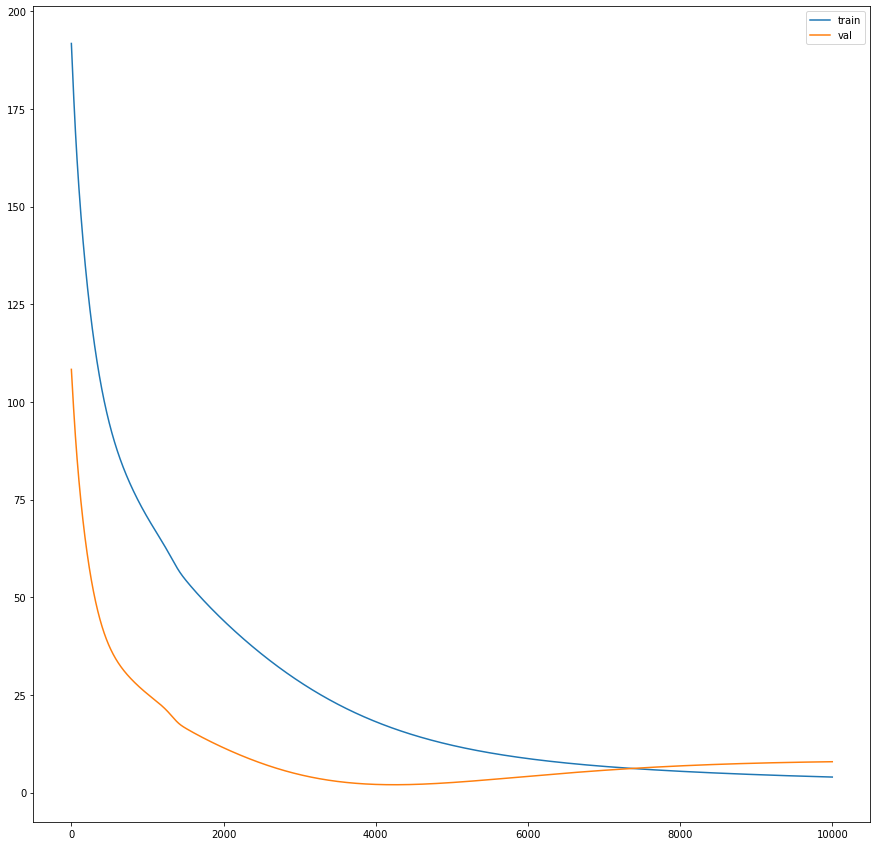

In [73]:
plt.figure(figsize=(15,15))
plt.plot(history['tr'], label='train')
plt.plot(history['val'], label='val')
plt.legend()

In [74]:
# now we can make a prediction 
with torch.no_grad():
    print('prediction', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

prediction tensor([[-0.8377],
        [13.9481]])
answer tensor([[ 3.],
        [15.]])
hidden tensor([[ 0.0179],
        [ 0.1196],
        [-0.0085],
        [-0.0671],
        [ 0.0080],
        [ 0.0014],
        [ 0.0170],
        [ 0.3091]])


In [75]:
def plot_result():
    from matplotlib import pyplot as plt

    t_range = torch.arange(20., 90.).unsqueeze(1)

    plt.figure(dpi=150)
    plt.xlabel("Fahrenheit")
    plt.ylabel("Celsius")
    plt.plot(t_u.numpy(), t_c.numpy(), 'o', label='data: tr+val')
    plt.plot(t_u_train.numpy(), t_c_train.numpy(), 'go', label='data: train')
    plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-', label='pred')
    plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
    plt.plot(t_u_val, seq_model(t_un_val).detach().numpy(), 'rx', label='val')
    plt.legend()
#

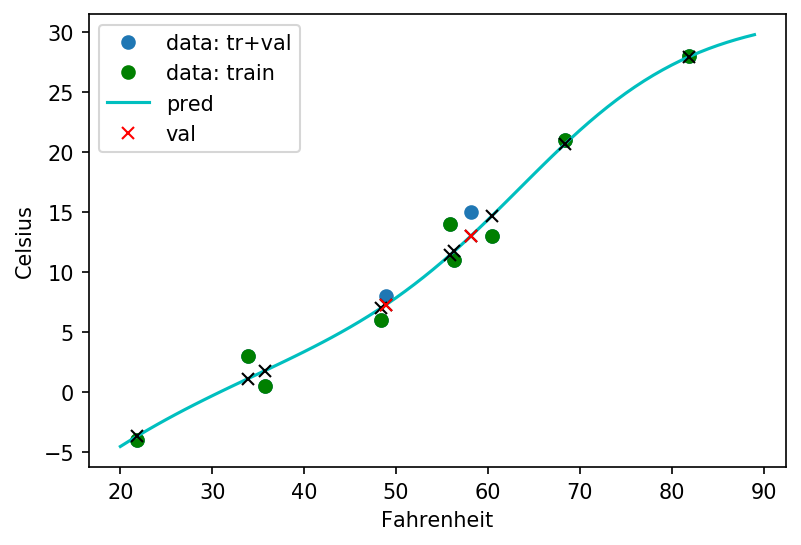

In [152]:
plot_result()

### Modify hyper parameters and see changes
1. the size of the hidden layer
2. n_epochs
3. learning rate

In [153]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

history = training_loop(
                    n_epochs = 25000, 
                    optimizer = optimizer,
                    model = seq_model,
                    loss_fn = nn.MSELoss(),
                    t_u_train = t_un_train,
                    t_u_val = t_un_val, 
                    t_c_train = t_c_train,
                    t_c_val = t_c_val)


Epoch 1, Training loss 200.89944458007812, Validation loss 148.89495849609375
Epoch 1000, Training loss 61.37677001953125, Validation loss 10.235350608825684
Epoch 2000, Training loss 34.10038375854492, Validation loss 5.943243026733398
Epoch 3000, Training loss 18.339576721191406, Validation loss 3.4725074768066406
Epoch 4000, Training loss 10.42494010925293, Validation loss 1.923828363418579
Epoch 5000, Training loss 7.417088031768799, Validation loss 1.260610580444336
Epoch 6000, Training loss 5.985826015472412, Validation loss 0.9413200616836548
Epoch 7000, Training loss 5.14970588684082, Validation loss 0.7882016897201538
Epoch 8000, Training loss 4.576574325561523, Validation loss 0.7146233916282654
Epoch 9000, Training loss 4.1466851234436035, Validation loss 0.6823500394821167
Epoch 10000, Training loss 3.807889223098755, Validation loss 0.6741494536399841
Epoch 11000, Training loss 3.5327863693237305, Validation loss 0.6814691424369812
Epoch 12000, Training loss 3.304951667785

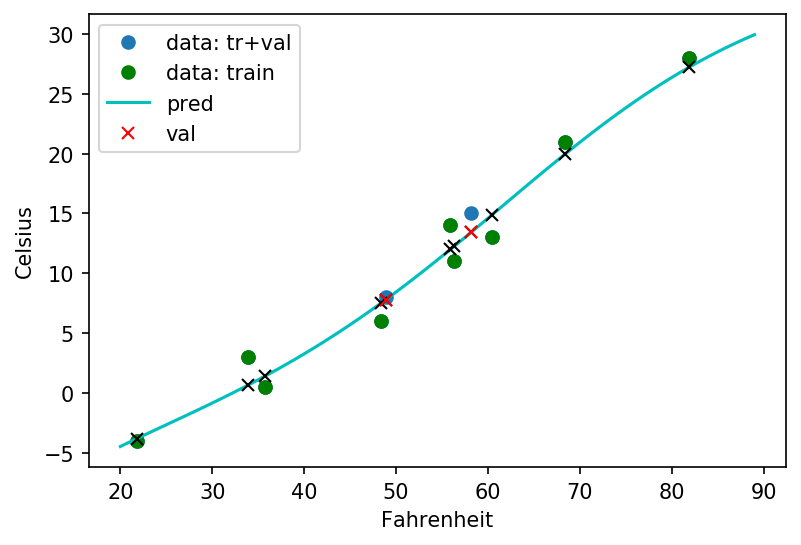

In [154]:
plot_result()

### More than two layers

In [172]:
# Exercises here!

neuron_count = [200, 100]

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count[0])),
    ('hidden_activation', nn.Tanh()),
    ('hidden_linear_2', nn.Linear(neuron_count[0], neuron_count[1])),
    ('hidden_activation', nn.Tanh()),
    ('hidden3', nn.Linear(neuron_count[1], 20)),
    ('tanh', nn.Tanh()),
    ('output_linear', nn.Linear(20, 1)),
]))
print(seq_model)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)
optimizer = optim.Adam(seq_model.parameters(), lr=1e-4)

history = training_loop(n_epochs = 25000, 
                        optimizer = optimizer,
                        model = seq_model,
                        loss_fn = nn.MSELoss(),
                        t_u_train = t_un_train,
                        t_u_val = t_un_val, 
                        t_c_train = t_c_train,
                        t_c_val = t_c_val)


Sequential(
  (hidden_linear): Linear(in_features=1, out_features=200, bias=True)
  (hidden_activation): Tanh()
  (hidden_linear_2): Linear(in_features=200, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=20, bias=True)
  (tanh): Tanh()
  (output_linear): Linear(in_features=20, out_features=1, bias=True)
)
Epoch 1, Training loss 190.38157653808594, Validation loss 137.5399627685547
Epoch 1000, Training loss 121.03599548339844, Validation loss 64.2696762084961
Epoch 2000, Training loss 88.50067901611328, Validation loss 37.74430465698242
Epoch 3000, Training loss 67.98201751708984, Validation loss 23.21253204345703
Epoch 4000, Training loss 51.93296813964844, Validation loss 12.702831268310547
Epoch 5000, Training loss 40.05988693237305, Validation loss 5.7902326583862305
Epoch 6000, Training loss 31.41830062866211, Validation loss 2.539288282394409
Epoch 7000, Training loss 24.119873046875, Validation loss 3.619278907775879
Epoch 8000, Training loss 17.75

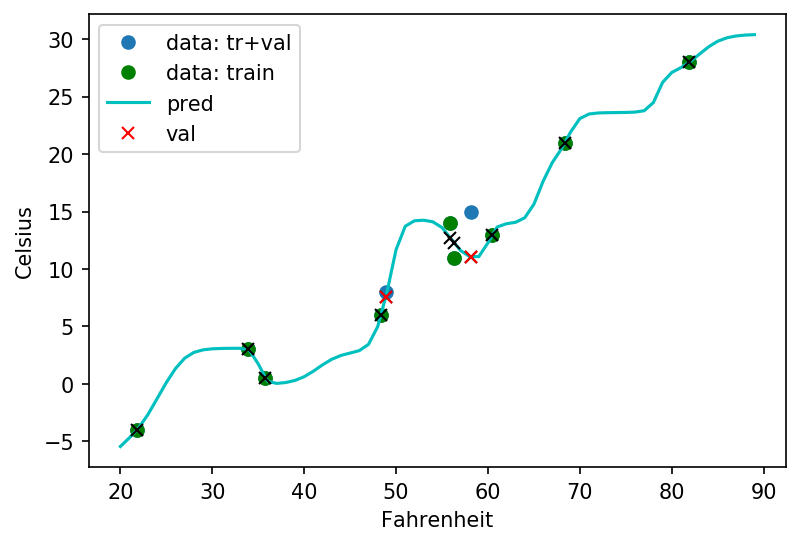

In [173]:
plot_result()

### Examining Loss-epoch curve is important to check overfitting

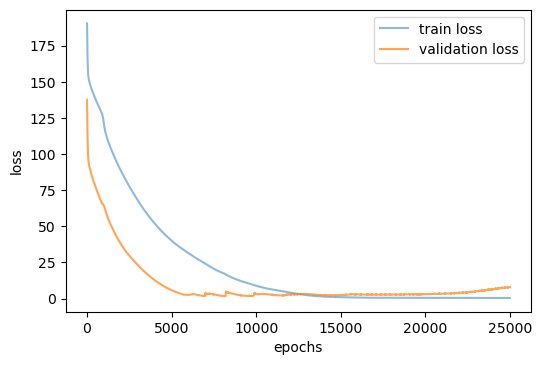

In [174]:
plt.figure(dpi=100)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history['tr'], label='train loss', alpha=0.5)
plt.plot(history['val'], label='validation loss', alpha=0.7)
plt.legend()

### Train loss is decreasing slow but validation loss turns up. Overfitting!

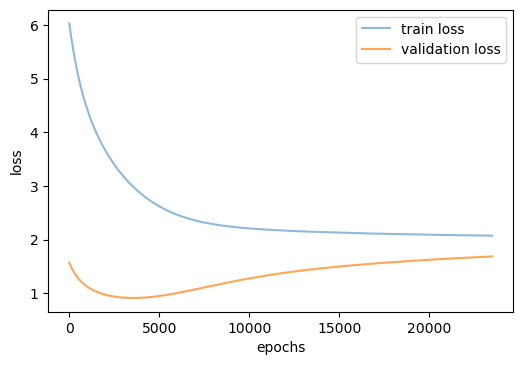

In [158]:
plt.figure(dpi=100)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history['tr'][1500:], label='train loss', alpha=0.5)
plt.plot(history['val'][1500:], label='validation loss', alpha=0.7)
plt.legend()

##  End of Part 1

---

## 2. Activation Functions

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2)

In [77]:
input_t = torch.arange(-3, 3.1, 0.1)
print('input_t: ', input_t)

input_t:  tensor([-3.0000, -2.9000, -2.8000, -2.7000, -2.6000, -2.5000, -2.4000, -2.3000,
        -2.2000, -2.1000, -2.0000, -1.9000, -1.8000, -1.7000, -1.6000, -1.5000,
        -1.4000, -1.3000, -1.2000, -1.1000, -1.0000, -0.9000, -0.8000, -0.7000,
        -0.6000, -0.5000, -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,
         0.2000,  0.3000,  0.4000,  0.5000,  0.6000,  0.7000,  0.8000,  0.9000,
         1.0000,  1.1000,  1.2000,  1.3000,  1.4000,  1.5000,  1.6000,  1.7000,
         1.8000,  1.9000,  2.0000,  2.1000,  2.2000,  2.3000,  2.4000,  2.5000,
         2.6000,  2.7000,  2.8000,  2.9000,  3.0000])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000,
        0.6000, 0.7000, 0.8000, 0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000,
        1.5000, 1.6000, 1.7000, 1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000,
        2.4000, 2.5000, 2.6000, 2.7000, 2.8000, 2.9000, 3.0000])

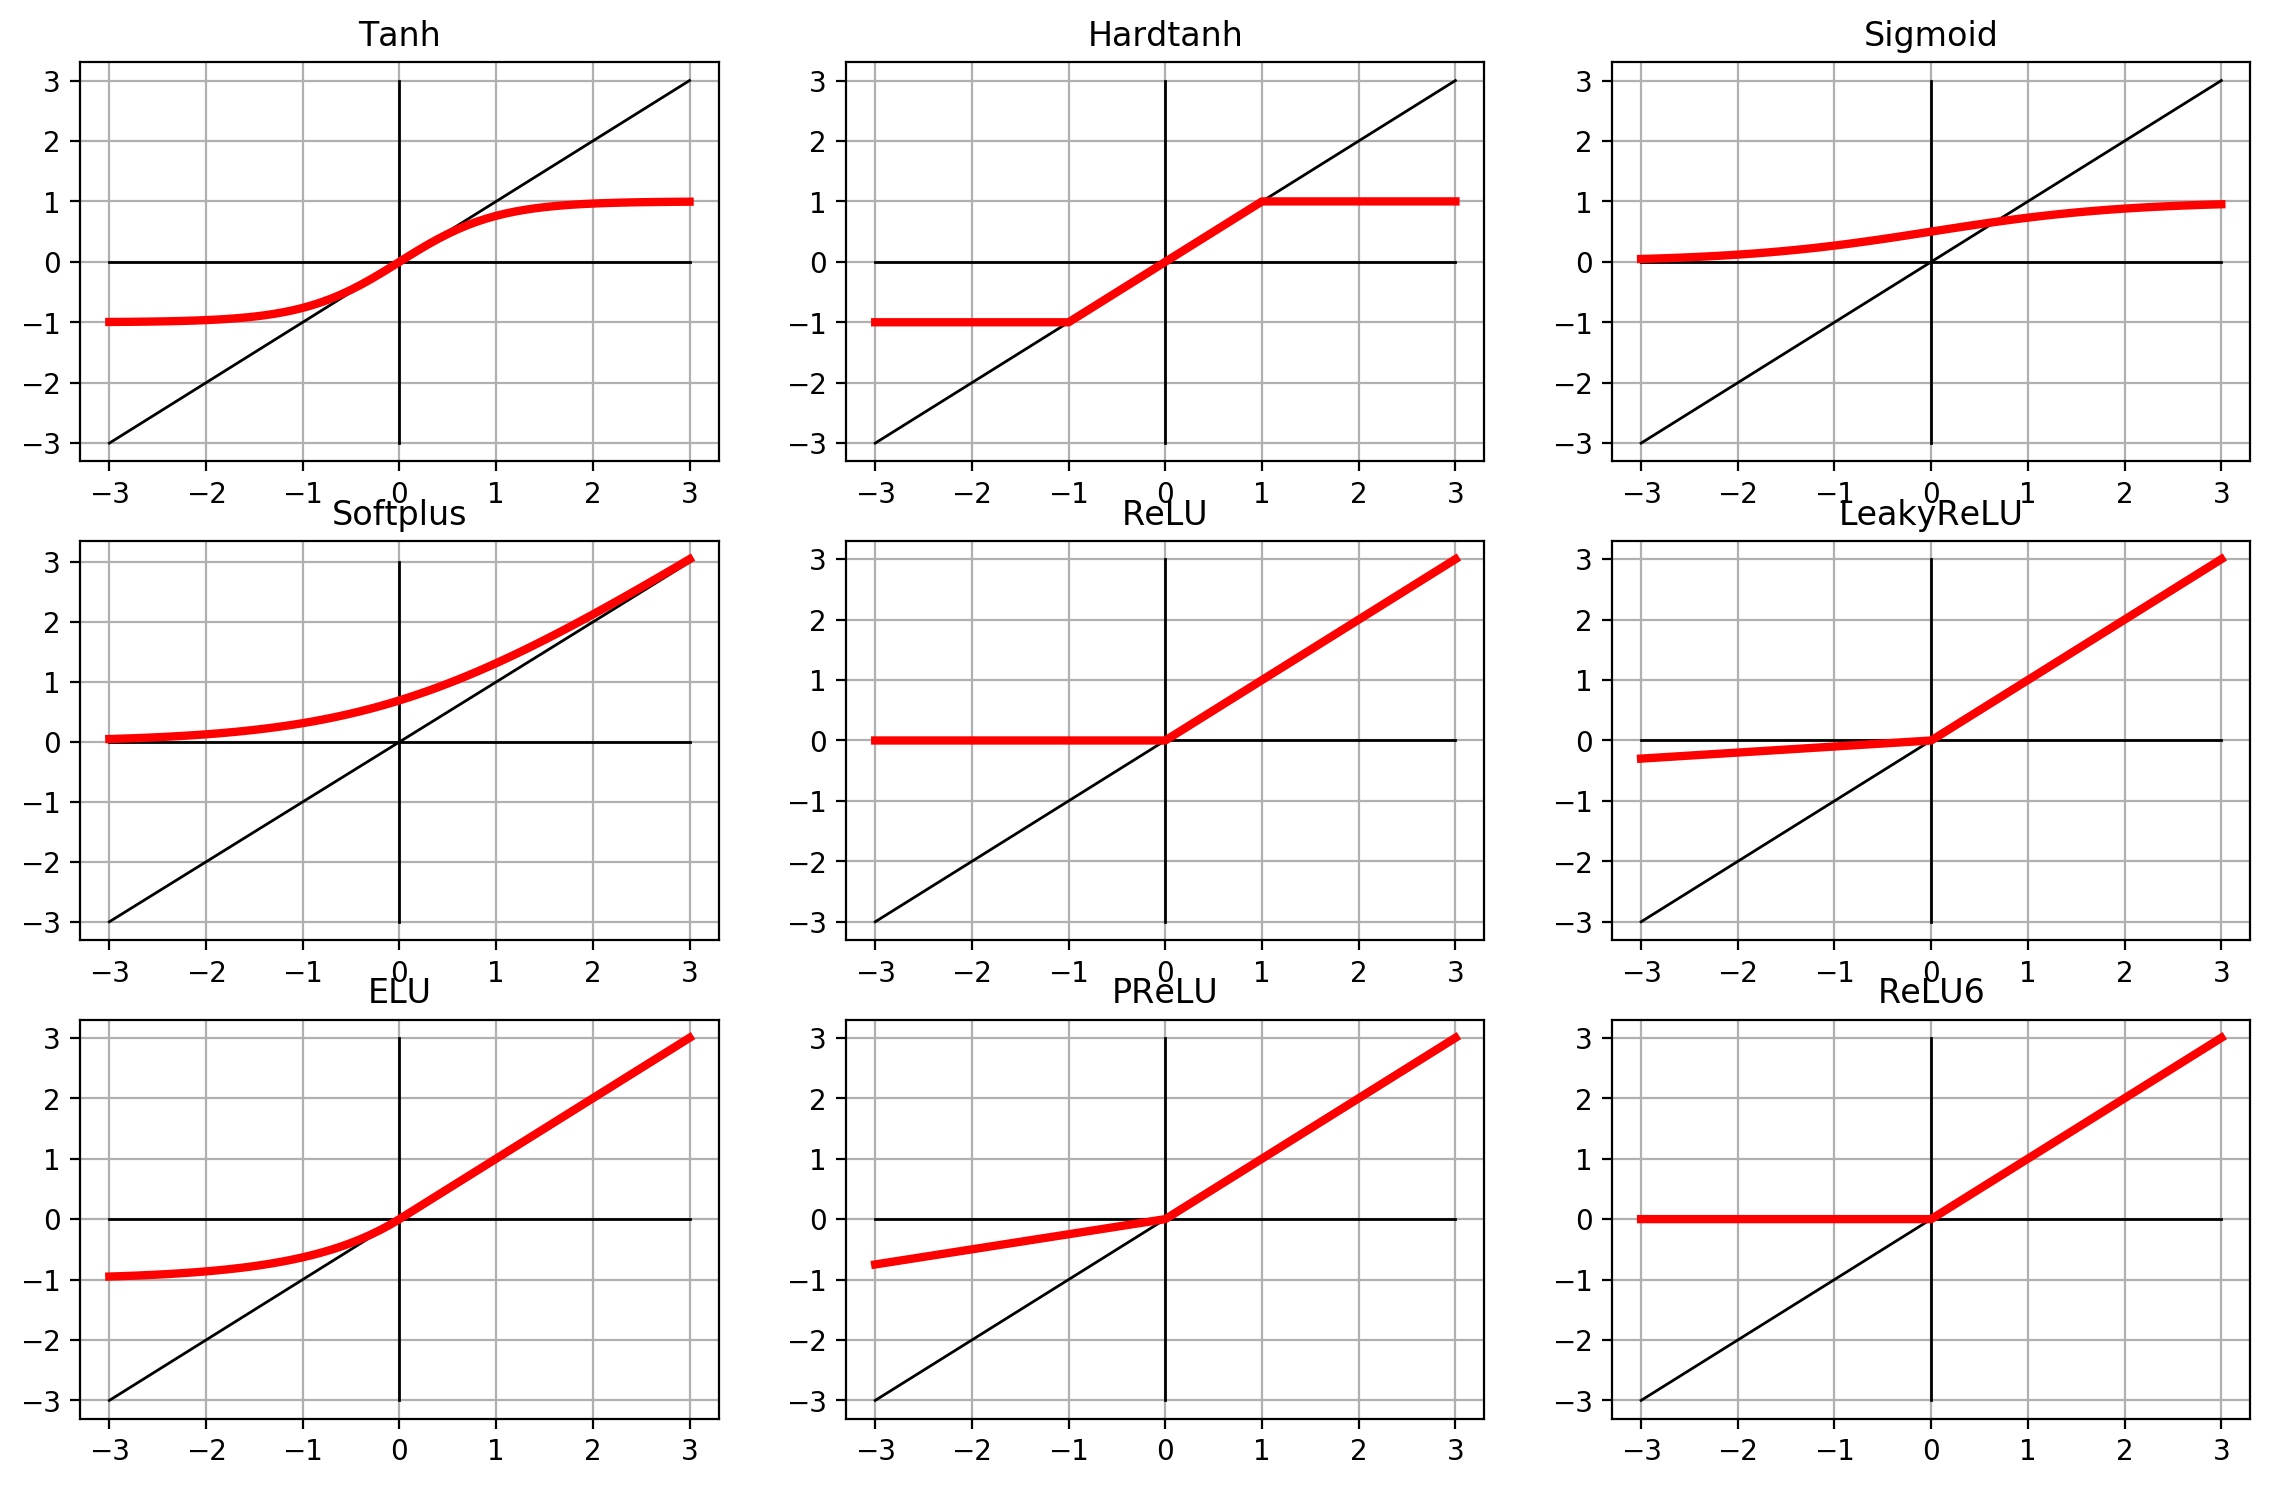

In [78]:
activation_list = [
    nn.Tanh(),
    nn.Hardtanh(),
    nn.Sigmoid(),
    
    nn.Softplus(),
    nn.ReLU(),
    nn.LeakyReLU(negative_slope=0.1),

    nn.ELU(),
    nn.PReLU(),
    nn.ReLU6()
]

fig = plt.figure(figsize=(14, 28), dpi=200)

for i, activation_func in enumerate(activation_list):
    subplot = fig.add_subplot(len(activation_list), 3, i+1)
    subplot.set_title(type(activation_func).__name__)
    
    output_t = activation_func(input_t)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1)
    plt.plot([-3,3], [0,0], 'k', linewidth=1)
    plt.plot([0,0], [-3,3], 'k', linewidth=1)
    plt.plot(input_t.numpy(), output_t.detach().numpy(), 'r', linewidth=3)

output_t

### Combination of `Tanh` and `Linear` results in a highly non-linear function

tensor([1.6885, 1.6924, 1.6967, 1.7015, 1.7064, 1.7112, 1.7155, 1.7184, 1.7190,
        1.7158, 1.7069, 1.6901, 1.6629, 1.6229, 1.5685, 1.5005, 1.4238, 1.3486,
        1.2913, 1.2713, 1.3060, 1.4017, 1.5384, 1.6643, 1.7191, 1.6667, 1.5191,
        1.3410, 1.2022, 1.1303, 1.1191, 1.1508, 1.2075, 1.2744, 1.3414, 1.4024,
        1.4547, 1.4979, 1.5328, 1.5605, 1.5824, 1.5997, 1.6132, 1.6239, 1.6324,
        1.6391, 1.6444, 1.6487, 1.6521, 1.6549, 1.6571, 1.6589, 1.6604, 1.6615,
        1.6625, 1.6633, 1.6639, 1.6644, 1.6649, 1.6652, 1.6655])

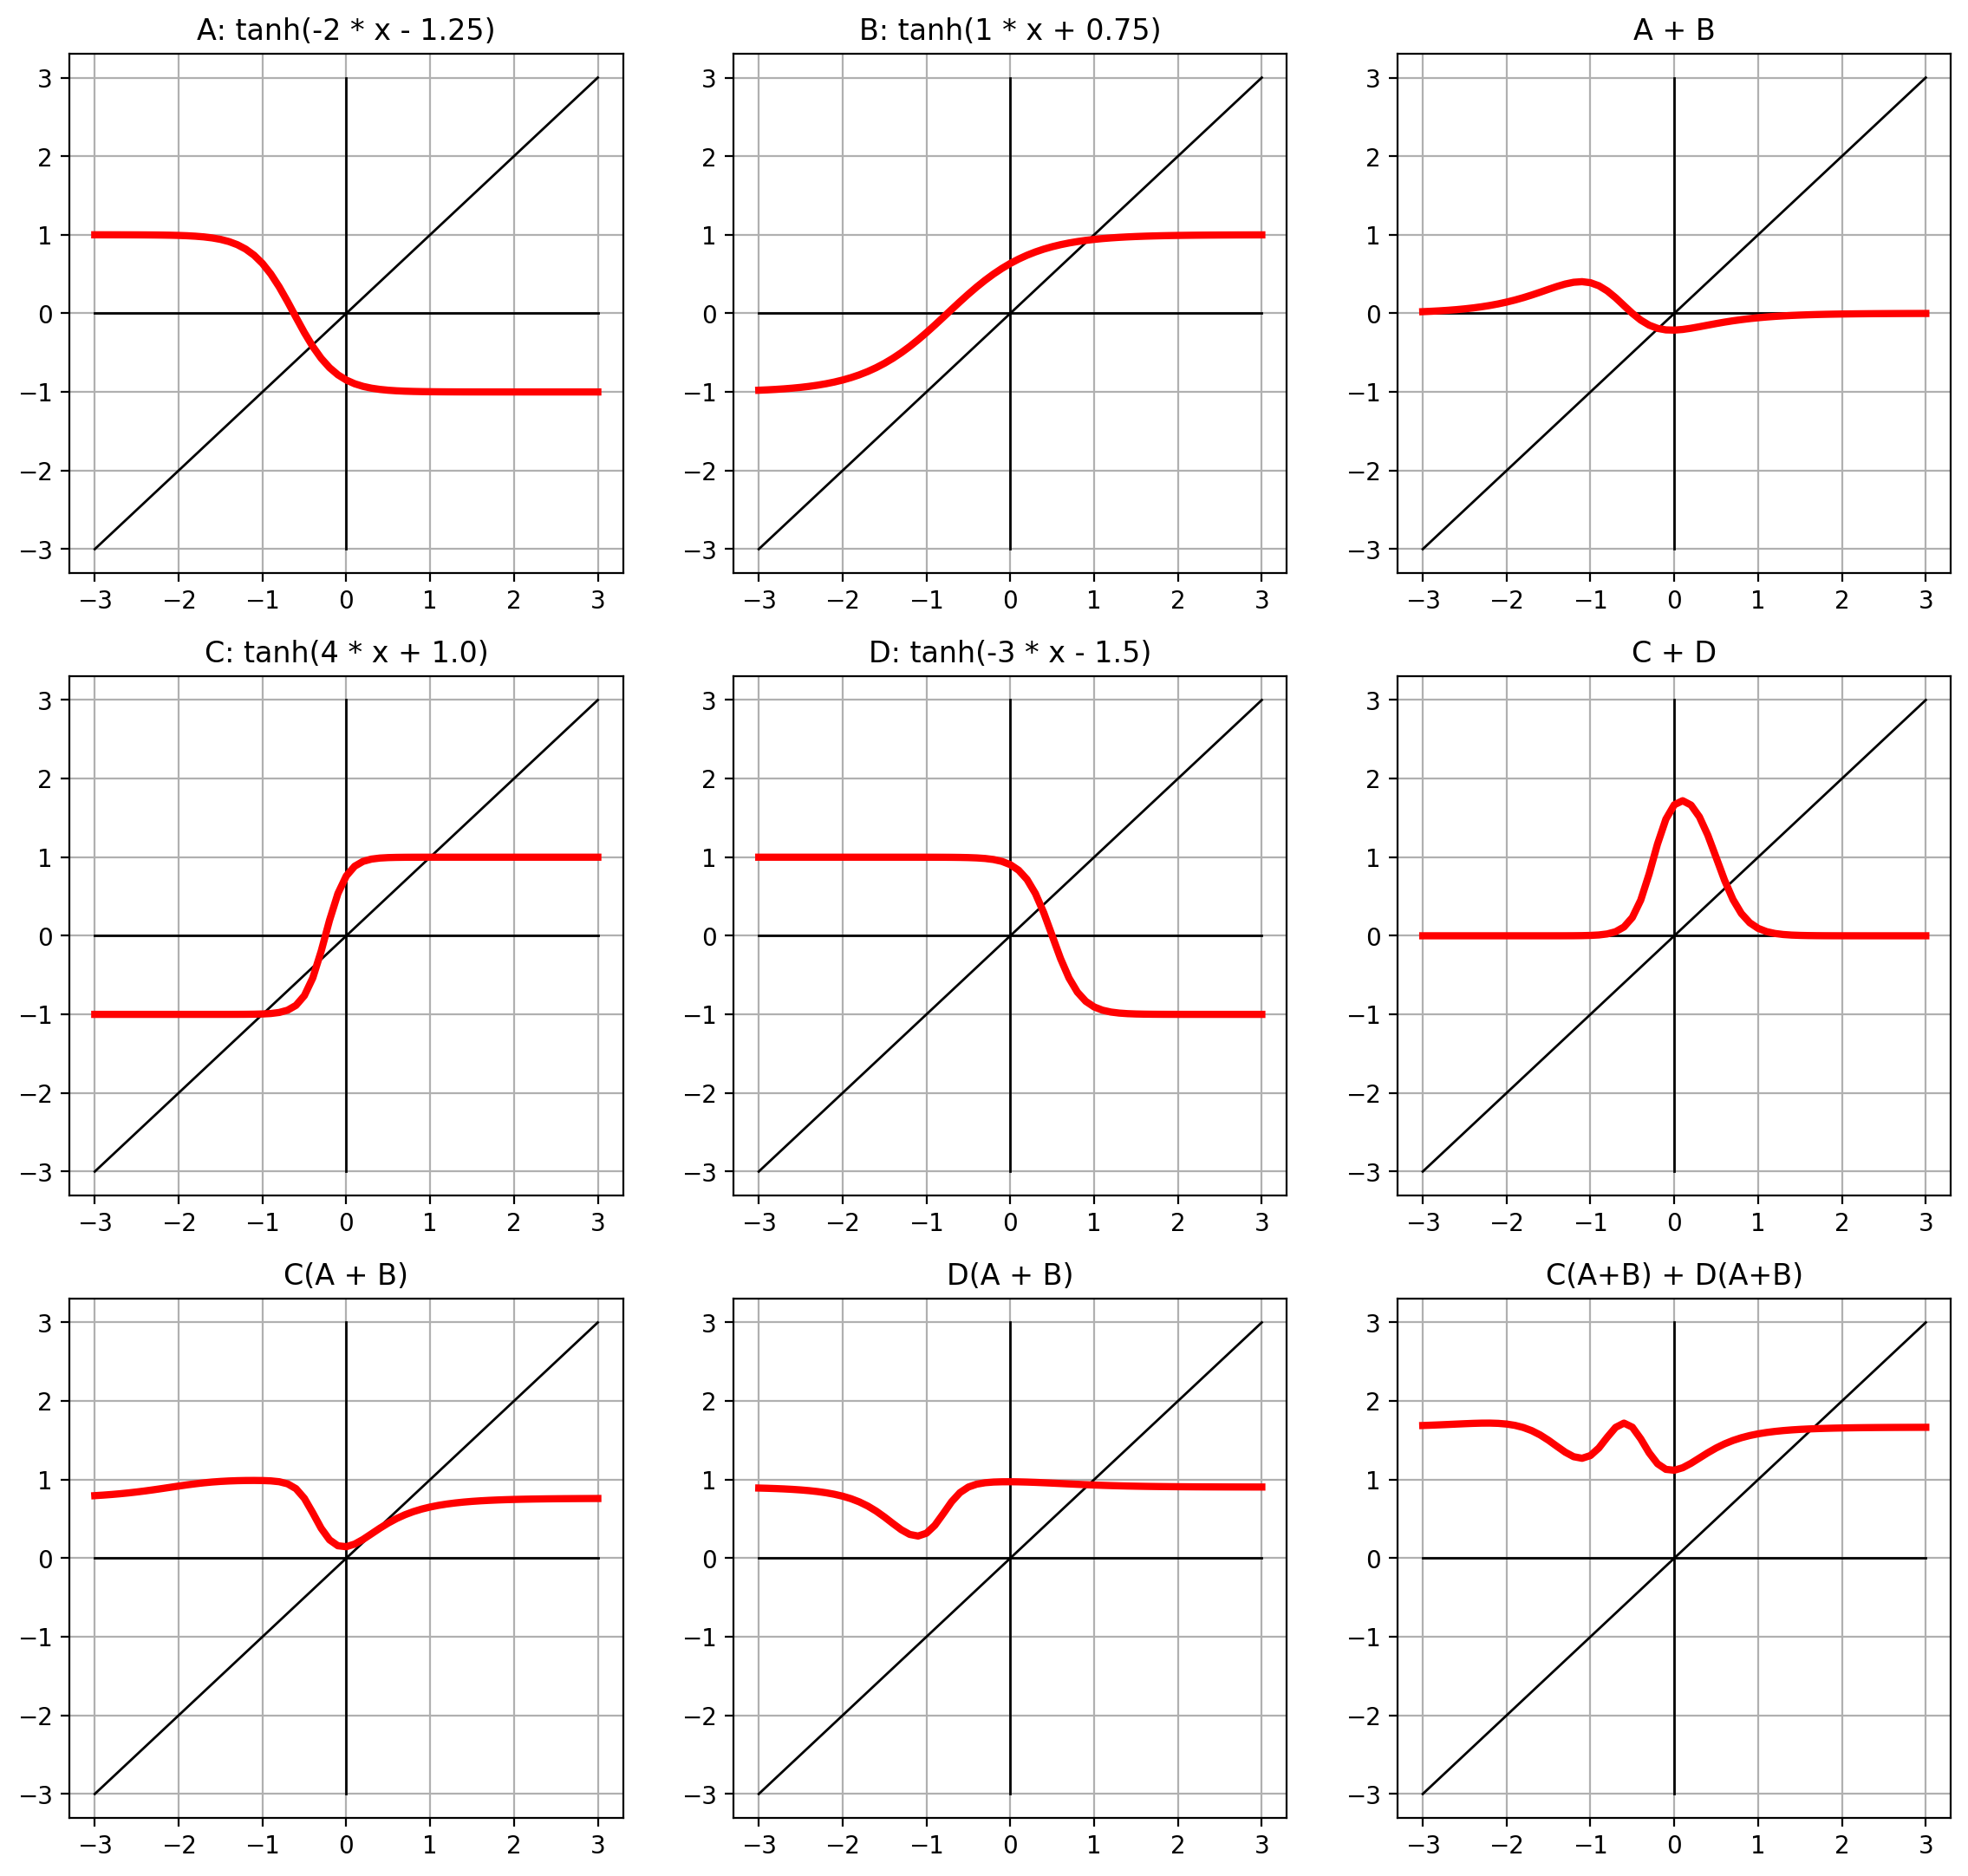

In [12]:
a = lambda x: nn.Tanh()(-2 * x - 1.25)
b = lambda x: nn.Tanh()( 1 * x + 0.75)
c = lambda x: nn.Tanh()( 4 * x + 1.)
d = lambda x: nn.Tanh()(-3 * x + 1.5)

wb_list = [
    ('A: tanh(-2 * x - 1.25)', a(input_t)),
    ('B: tanh(1 * x + 0.75)', b(input_t)),
    ('A + B', a(input_t) + b(input_t)),

    ('C: tanh(4 * x + 1.0)', c(input_t)),
    ('D: tanh(-3 * x - 1.5)', d(input_t)),
    ('C + D', c(input_t) + d(input_t)),

    ('C(A + B)', c(a(input_t) + b(input_t))),
    ('D(A + B)', d(a(input_t) + b(input_t))),
     
    ('C(A+B) + D(A+B)', c(a(input_t) + b(input_t)) + d(a(input_t) + b(input_t))),
]

fig = plt.figure(figsize=(14, 42), dpi=200)

for i, (title_str, output_t) in enumerate(wb_list):
    subplot = fig.add_subplot(len(wb_list), 3, i+1)
    subplot.set_title(title_str)
    
    plt.grid()
    plt.plot(input_t.numpy(), input_t.numpy(),'k', linewidth=1)
    plt.plot([-3,3], [0,0], 'k', linewidth=1)
    plt.plot([0,0], [-3,3], 'k', linewidth=1)
    plt.plot(input_t.numpy(), output_t.numpy(), 'r', linewidth=3)

output_t

### End Part 2

---

## 3. `torch.nn` Module Subclassing

In [79]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

torch.set_printoptions(edgeitems=2)

### `nn.Sequential()`

In [80]:
seq_model = nn.Sequential(
            nn.Linear(1, 11), # <1>
            nn.Tanh(),
            nn.Linear(11, 1)) # <1>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=11, bias=True)
  (1): Tanh()
  (2): Linear(in_features=11, out_features=1, bias=True)
)

### `nn.Sequential(OrderedDict([ ]))` for ordered and named layers

In [165]:
from collections import OrderedDict

namedseq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 12)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(12 , 1))
]))

namedseq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=12, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=12, out_features=1, bias=True)
)

### SubClass of `nn.Module` for most flexible modeling

In [166]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()  # <1>
        
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t
#

subclass_model = SubclassModel()
subclass_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [167]:
for type_str, model in [('seq', seq_model), ('namedseq', namedseq_model), ('subclass', subclass_model)]:
    print(type_str)
    for name_str, param in model.named_parameters():
        print("{:21} {:19} {}".format(name_str, str(param.shape), param.numel()))
        
    print()

seq
0.weight              torch.Size([11, 1]) 11
0.bias                torch.Size([11])    11
2.weight              torch.Size([1, 11]) 11
2.bias                torch.Size([1])     1

namedseq
hidden_linear.weight  torch.Size([12, 1]) 12
hidden_linear.bias    torch.Size([12])    12
output_linear.weight  torch.Size([1, 12]) 12
output_linear.bias    torch.Size([1])     1

subclass
hidden_linear.weight  torch.Size([13, 1]) 13
hidden_linear.bias    torch.Size([13])    13
output_linear.weight  torch.Size([1, 13]) 13
output_linear.bias    torch.Size([1])     1



### Activation Functions can be replaced by functions 
- in this case the print out does not show the names of activation functions

In [168]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_linear = nn.Linear(1, 14)  
                                                # <1>
        self.output_linear = nn.Linear(14, 1)
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = torch.tanh(hidden_t) # <2>
        output_t = self.output_linear(activated_t)
        
        return output_t
    
func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)

### Composition of `nn.Sequential()`

In [169]:
seq_model = nn.Sequential(
                nn.Sequential( # <1>
                        nn.Linear(1, 11), 
                        nn.Tanh(),
                        nn.Linear(11, 21),
                        nn.Tanh()),
                nn.Linear(21, 1)
            )
    
seq_model

Sequential(
  (0): Sequential(
    (0): Linear(in_features=1, out_features=11, bias=True)
    (1): Tanh()
    (2): Linear(in_features=11, out_features=21, bias=True)
    (3): Tanh()
  )
  (1): Linear(in_features=21, out_features=1, bias=True)
)

## Composition of Subclasss

In [170]:
class SubclassModel(nn.Module):
    def __init__(self, hidden1=13, hidden2=21):
        super(SubclassModel, self).__init__()  # <1>
        
        self.hidden_linear = nn.Linear(1, hidden1)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(hidden1, hidden2)
        self.tanh2 = nn.Tanh()
        
    def forward(self, input):
        hidden_t = self.hidden_linear(input)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.tanh2(self.output_linear(activated_t))
        
        return output_t
#

class SubclassModel_2(nn.Module):
    def __init__(self):
        super().__init__()  # <1>
        
        self.front = SubclassModel(11, 51)
        
        self.hidden_linear = nn.Linear(51, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, x):
        front = self.front(x)
        hidden_t = self.hidden_linear(front)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t
#

subclass_model = SubclassModel_2()
subclass_model

SubclassModel_2(
  (front): SubclassModel(
    (hidden_linear): Linear(in_features=1, out_features=11, bias=True)
    (hidden_activation): Tanh()
    (output_linear): Linear(in_features=11, out_features=51, bias=True)
    (tanh2): Tanh()
  )
  (hidden_linear): Linear(in_features=51, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [171]:
input_t = torch.randn([7,1])
print(input_t)

net_model = SubclassModel_2()  # create an instance

output = net_model(input_t) # apply
print(output)

tensor([[-0.6626],
        [-0.8250],
        [-2.7054],
        [ 0.2916],
        [ 0.8908],
        [ 1.8822],
        [-0.3923]])
tensor([[0.2615],
        [0.2687],
        [0.3244],
        [0.2201],
        [0.1881],
        [0.1280],
        [0.2498]], grad_fn=<AddmmBackward>)


### End of Part 3

## End of Chapter 6

## Exercises

1. [Kaggle House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)
    - Use numerical data only, for simplicity, to predict `SalePrice`.
        - A data file for this experiment is provided.
    - submit the notebook, your score, and a screen capture of your submission result to kaggle leader board.
    - refer to the book Dive to Deep Learning, Chapter 4.10, which has a good description on how to do it.
1. https://data.world/datasets/regression
1. https://www.kaggle.com/roche-data-science-coalition/uncover?utm_medium=email&utm_source=intercom&utm_campaign=uncover-roche-email